In [1]:
%matplotlib widget

from mpl_toolkits import mplot3d

import time
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def draw_coordinate_frame(ax, T, R):
    tx, ty, tz = T
    new_x = R @ np.array([1, 0, 0.0]) + T
    new_y = R @ np.array([0, 1, 0.0]) + T
    new_z = R @ np.array([0, 0, 1.0]) + T
    
    a = Arrow3D([tx, new_x[0]], [ty, new_x[1]], [tz, new_x[2]], **arrow_prop_dict, color='r')
    ax.add_artist(a)
    a = Arrow3D([tx, new_y[0]], [ty, new_y[1]], [tz, new_y[2]], **arrow_prop_dict, color='b')
    ax.add_artist(a)
    a = Arrow3D([tx, new_z[0]], [ty, new_z[1]], [tz, new_z[2]], **arrow_prop_dict, color='g')
    ax.add_artist(a)
    
def draw_vec(ax, p1, p2, color):
    a = Arrow3D([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], **arrow_prop_dict, color=color)
    ax.add_artist(a)

In [2]:
def project_to_plane(origin, vec):
    ground_normal, ground_point = np.array([0, 0, 1]), np.array([0, 0, 0])
    t = (-ground_normal @ (origin - ground_point)) / (ground_normal @ vec)
    return t

In [3]:
from drone_mpc import DroneMPC
from scipy.spatial.transform import Rotation

data = np.load("../rosbags/drone_target_sample.npz", allow_pickle=True)
x0 = data["drone_x"]
T = x0[:3]

q0 = data["drone_q"]
R = Rotation.from_quat(q0)

N = 10
pix_3d = data["pixel_drone"]
target_traj = data["target_traj"]
con = DroneMPC(N=N)


phi = R.as_euler("XYZ")[0]
user_sq_dist = 0.5
start_time = time.time()
X_mpc, U_mpc = con.solve(
    x0=x0, u0=None, target_pixel=pix_3d,
    phi0=phi, target_traj=target_traj, user_sq_dist=user_sq_dist)
print("time taken: %.3fs" % (time.time() - start_time))

[[1.  0.  0.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0.1 0.  0. ]
 [0.  0.  1.  0.  0.  0.1 0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]
[[0.005 0.    0.    0.   ]
 [0.    0.005 0.    0.   ]
 [0.    0.    0.005 0.   ]
 [0.1   0.    0.    0.   ]
 [0.    0.1   0.    0.   ]
 [0.    0.    0.1   0.   ]
 [0.    0.    0.    0.1  ]]
time taken: 11.580s


In [4]:
X_mpc

array([[ 2.08938140e-02,  2.53066737e-02,  7.99154234e+00,
        -1.90564711e-02, -1.27188843e-02, -1.65763628e-02,
         7.88326360e-01],
       [ 5.39318992e-01, -5.93160963e-01,  7.85825587e+00,
         1.03827973e+01, -1.23509845e+01, -2.64794817e+00,
         9.70131934e-01],
       [ 1.77535365e+00, -1.38708315e+00,  7.52500737e+00,
         1.43360858e+01, -3.53149747e+00, -4.01639519e+00,
         1.46247926e+00],
       [ 3.00527271e+00, -1.18047960e+00,  7.09262564e+00,
         1.02641599e+01,  7.65844476e+00, -4.63095811e+00,
         1.91048605e+00],
       [ 3.67377571e+00, -1.38402031e-01,  6.61889082e+00,
         3.10917614e+00,  1.31805782e+01, -4.84364097e+00,
         2.29281878e+00],
       [ 3.65719510e+00,  1.21486113e+00,  6.13311355e+00,
        -3.43779076e+00,  1.38843626e+01, -4.87189133e+00,
         2.60835828e+00],
       [ 3.08104167e+00,  2.51691463e+00,  5.64752179e+00,
        -8.08315079e+00,  1.21574981e+01, -4.83995861e+00,
         2.8514576

In [5]:
np.linalg.norm(x0[:2] - data["target_traj"][0][:2])**2

21.878236126772958

[0.7883263604479005, 0.46650359121892887, 0.0010596015757493582]
[7.88327183e-01 1.62825303e-04 1.66669236e-03]


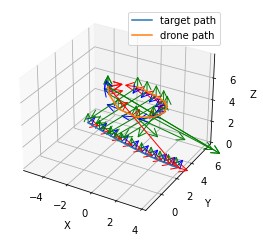

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
target_x = [data["target_traj"][i][0] for i in range(len(data["target_traj"]))]
target_y = [data["target_traj"][i][1] for i in range(len(data["target_traj"]))]
target_z = [data["target_traj"][i][2] for i in range(len(data["target_traj"]))]
ax.plot(target_x, target_y, target_z, label='target path')
for target_pos in data["target_traj"]:
    draw_coordinate_frame(ax, T=target_pos, R=np.eye(3))
    
ax.plot(X_mpc[:,0], X_mpc[:,1], X_mpc[:,2], label='drone path')
for i in range(X_mpc.shape[0]):
    rot = Rotation.from_euler("ZYX", [X_mpc[i, -1], 0, 0]).as_matrix()
    draw_coordinate_frame(ax, T=X_mpc[i, :3], R=rot)
    desired_vec = rot @ pix_3d
    t = project_to_plane(X_mpc[i, :3], desired_vec)
    draw_vec(ax, X_mpc[i, :3], desired_vec*t + X_mpc[i, :3], color='g')
draw_coordinate_frame(ax, T=T, R=R.as_matrix())

# vec from drone to target
true_vec = data["target_traj"][0] - x0[:3]
draw_vec(ax, x0[:3], data["target_traj"][0], color='r')

# desired vec (center of image plane)
yaw = x0[-1]
vel = np.array([x0[3], x0[4], x0[5]])
vel = vel / np.linalg.norm(vel)
theta = math.asin(-vel[1])  # pitch
print([yaw, theta, phi])
print(R.as_euler("ZYX"))
fake_R = Rotation.from_euler('ZYX', [yaw, 0, 0])
desired_vec = fake_R.as_matrix() @ pix_3d
t = project_to_plane(T, desired_vec)
draw_vec(ax, T, desired_vec*t + T, color='g')

ax.legend()
plt.show()